## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"
# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [2]:
# Install requirements
!python -m pip install -r requirements.txt

## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

#### Data loader without Normalization

In [4]:
# Define transforms
non_normalized_tranform = transforms.Compose([transforms.ToTensor()])

# Create train set and define loader
non_normalized_train_data = torchvision.datasets.MNIST('data', train=True, download=True, transform=non_normalized_tranform)
nn_train_loader = torch.utils.data.DataLoader(non_normalized_train_data, batch_size=len(non_normalized_train_data))

#### Load train data and split it into training, validation, and test sets
proportions 60%, 20%, and 20%

In [5]:
# Define transforms
# For normalization use calculated values: mean, std
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307), (0.3081))])

# Create train set and define train dataloader
train_data = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
labels = train_data.targets

# First, split the data into train (60%) and temporary (40%) sets
data_train, data_temp, labels_train, labels_temp = train_test_split(train_data, labels, test_size=0.4, random_state=42)

# Then, split the temporary set into validation (20%) and test (20%) sets
data_valid, data_test, labels_valid, labels_test = train_test_split(data_temp, labels_temp, test_size=0.5, random_state=42)


#### Data loader with normalization

In [6]:
# define train loader
train_loader = torch.utils.data.DataLoader(data_train, batch_size=250, shuffle=True)

# define test dataloader
# test data is split from train_data, no need to load it from MNIST:
# test_data = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=250)

# define validation loader
valid_loader = torch.utils.data.DataLoader(data_valid, batch_size=250)

## Justify your preprocessing

- `transforms.ToTensor()` - converting PIL image to tensor.
- `transforms.Normalize` - helps learn faster. Normalization can also help with the diminishing and exploding gradients.

In [7]:
# You can plot image values by using `plot` function - it takes data loader as an argument

def plot(loader):
  data = next(iter(loader))
  # Calculation of the Mean and Standart deviation (std)
  print(data[0].mean(), data[0].std())
  
  data_list = np.array(data[0])
  flatten_data_list = data_list.flatten()
  
  # plot image values
  plt.hist(flatten_data_list)
  
  # plot mean value
  plt.axvline(data[0].mean(), linestyle='--')
  plt.show()

tensor(0.1307) tensor(0.3081)


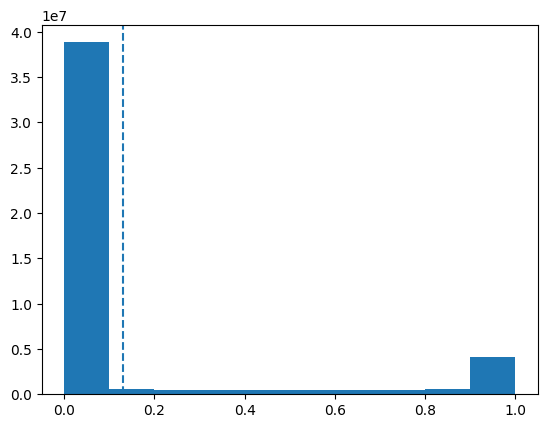

tensor(-0.0026) tensor(0.9980)


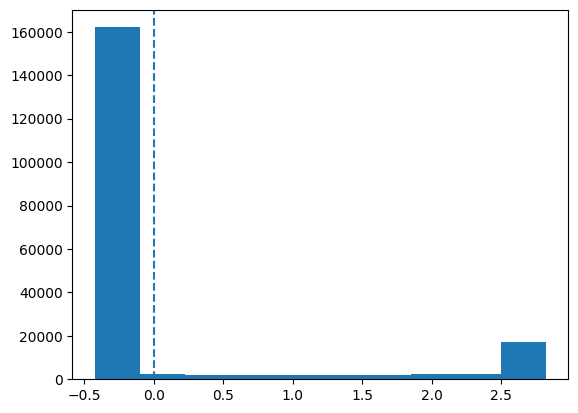

In [8]:
# Plot normalized data or non normalized data by calling plot function

# non normalized values
plot(nn_train_loader)
# normalized values
plot(train_loader)

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [9]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T, cmap='gray')
        plt.show()

8


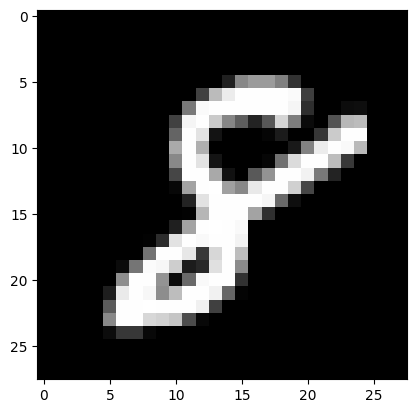

0


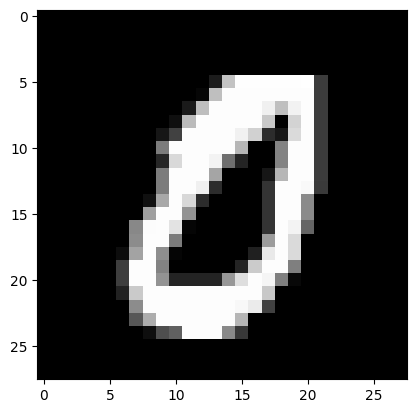

2


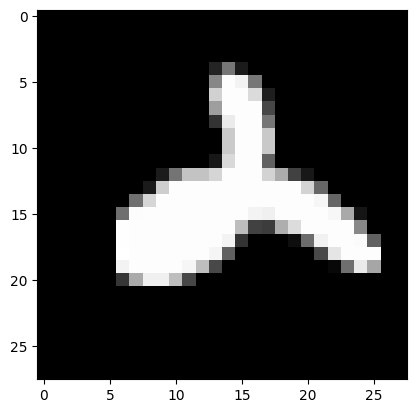

1


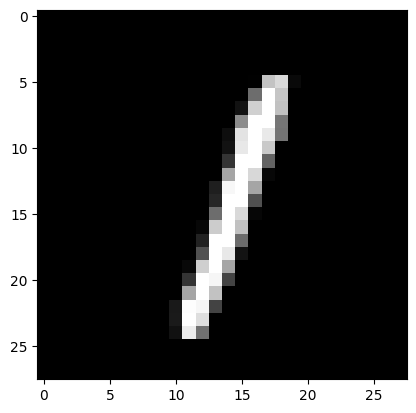

1


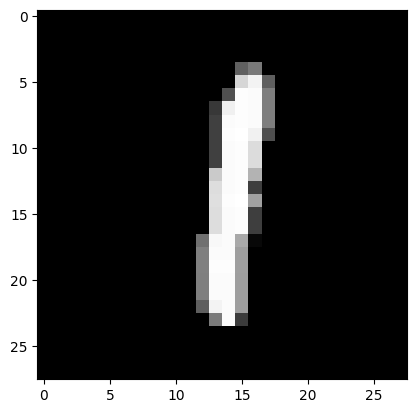

5


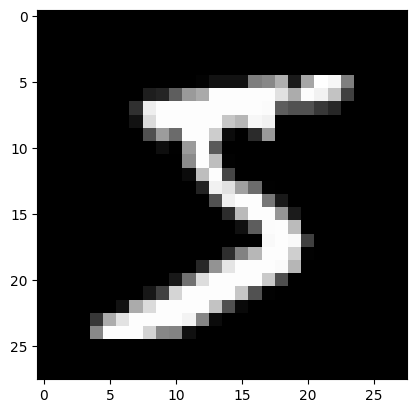

0


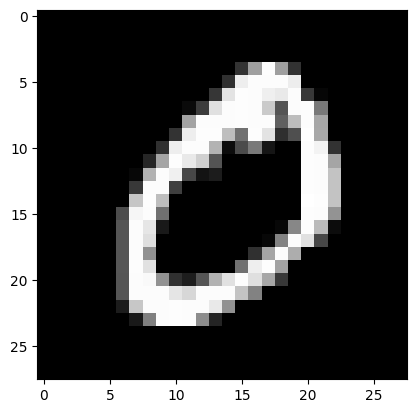

4


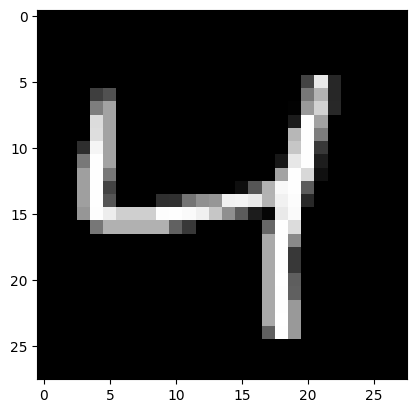

1


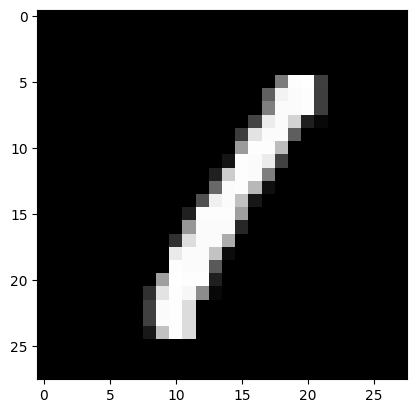

9


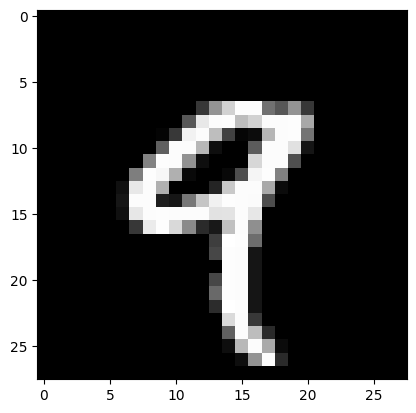

In [10]:
# Explore data

# normalized data
show5(train_loader)

# non normlized
show5(nn_train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.fc3(x)
        
model = Model() 

## Optimizer and Loss function

In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()

## Training Loop - Running Neural Network

In [13]:
train_val_loss_history = []
train_val_accuracy_history = []

def train_model(model, train_loader, optimizer, criterion, epochs=10):
# Will be used for early stopping
	best_val_loss = float('inf')
	threshold = 0.001
	counter = 0
	patience = 3
 
	# Train the model
	for epoch in range(epochs):
		# Switch to training mode
		model.train()

		train_loss = 0.0
		train_correct = 0
		for batch in train_loader:
			images, labels = batch
			optimizer.zero_grad()
			outputs = model(images)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()

			_, predicted_class = torch.max(outputs.data, 1)
			train_correct += (predicted_class == labels).sum().item()
			train_loss += loss.item()

		train_val_loss_history.append(train_loss / len(train_loader.dataset))
		train_val_accuracy_history.append(train_correct / len(train_loader.dataset))
		print(f'Epoch: {epoch + 1}, Accuracy: {train_correct / len(train_loader.dataset):.2f}, Loss: {train_loss / len(train_loader.dataset):.4f}')

		val_loss = 0.0
		val_correct = 0

		# Switch to evaluation mode
		model.eval()
		with torch.no_grad():
    
			for inputs, labels in valid_loader:
				outputs = model(inputs)
				loss = criterion(outputs, labels)
				val_loss += loss.item()
				_, predicted = torch.max(outputs.data, 1)
				val_correct += (predicted == labels).sum().item()
		print(f'Validation accuracy: {val_correct / len(test_loader.dataset):.2f}, Validation loss: {val_loss / len(test_loader.dataset):.4f}')

		# Early stopping
		if best_val_loss > val_loss:
			best_val_loss = val_loss

		diff = best_val_loss - val_loss
		if diff <= threshold:
			counter += 1

		if counter >= patience:
			break
 

In [17]:
train_model(model, train_loader, optimizer, criterion, 10)

Epoch: 1, Accuracy: 0.29, Loss: 0.0087
Validation accuracy: 0.70, Validation loss: 0.0071
Epoch: 2, Accuracy: 0.86, Loss: 0.0065
Validation accuracy: 0.90, Validation loss: 0.0063
Epoch: 3, Accuracy: 0.91, Loss: 0.0062
Validation accuracy: 0.93, Validation loss: 0.0062


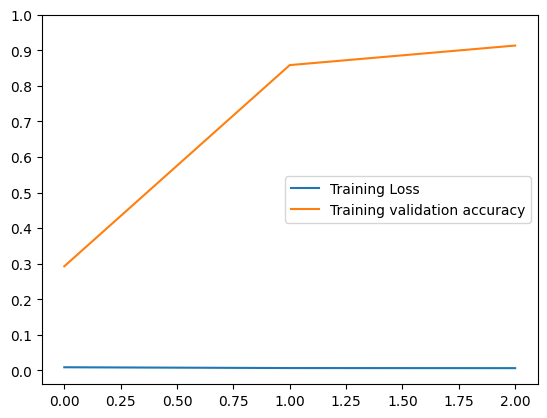

In [18]:
plt.plot(train_val_loss_history, label="Training Loss")
plt.plot(train_val_accuracy_history, label="Training validation accuracy")
plt.legend()
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

In [19]:
def test_model(model, test_loader):
  correct = 0
  total = 0
  
  model.eval()
  with torch.no_grad():
   	# test loop
    for inputs, targets in test_loader:
      outputs = model(inputs)
      _, predicted_image = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += (predicted_image == targets).sum().item()
      
    print('Accuracy of the model on the test set: %d %%' % (100 * correct / total))

In [20]:
# run test loop
test_model(model, test_loader)

Accuracy of the model on the test set: 92 %


In [21]:
# Save the weights of the trained model
torch.save(model.state_dict(), 'weights.pth')